# Filter Out Duplicate Questions

In [2]:
import os
import polars as pl
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

import faiss
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert.data import Queries, Collection
from colbert import Indexer, Searcher

In [254]:
train_sets = []

test = pl.read_csv('data/train.csv')
test = test.rename({'prompt': 'question'})
test = test.drop(columns="id")


def read_training_files(file_paths, dataset_name):
    if type(file_paths) == str:
        file_paths = [file_paths]
        
    if file_paths[0].endswith('.parquet'):
        train_raw = pl.concat(
            [pl.read_parquet(file) for file in file_paths]
        )
    elif file_paths[0].endswith('.csv'):
        train_raw = pl.concat(
            [pl.read_csv(file) for file in file_paths]
        )
    
    if 'prompt' in train_raw.columns:
        train_raw = train_raw.rename({'prompt': 'question'})
    
    train_cols = ['question', 'A', 'C', 'B', 'D', 'E', 'answer']
    train_raw = train_raw[train_cols]
    train_raw = train_raw.select(pl.all()\
                         .fill_null('N/A'))\
                         .with_columns(dataset_name=pl.lit(dataset_name))
    train_sets.append(train_raw)


read_training_files('./data/daniel_train/combined_deduped.parquet', 'daniel')
read_training_files('./data/6000_wiki_en_sci_questions_with_excerpts.csv', 'osmu_sci_6k')
read_training_files('./data/osmu_5900_examples.csv', 'osmu_5_9k')
read_training_files('./data/osmulski_15k.csv', 'osmu_15k')
read_training_files('./data/mgoksu_13k.csv', 'mgoksu')
read_training_files('./data/gigkpeaeums_train.csv', 'gigkpea')
    
train = pl.concat(train_sets)
f'{train.shape[0]:,}'

'54,725'

## Create ColBERT Indexer for questions

In [3]:
train = pl.read_parquet('./data/large_train_deduped.parquet')
train.shape

(54725, 9)

In [257]:
train = train.drop('question_id').with_row_count('question_id')

In [258]:
max_words = 100
doc_maxlen = 150
query_maxlen = 150
nbits = 2
colbert_path = Path(f'./data/question_indexer_max_words_{max_words}')
os.makedirs(colbert_path, exist_ok=True)

In [259]:
checkpoint = './checkpoints/colbertv2.0'
indexer_name = f"question_indexer"

questions_file = str(colbert_path/'questions') + '.tsv'

train.with_columns(pl.col('question').str.replace_all('\n', ' ').alias('question'))[['question_id', 'question']]\
     .write_csv(questions_file, separator='\t', has_header=False)
c_collection = Collection(questions_file)
f'Loaded {len(c_collection):,} passages'

os.environ['COLBERT_LOAD_TORCH_EXTENSION_VERBOSE'] = 'False'

config = ColBERTConfig(
    doc_maxlen=doc_maxlen,
    query_maxlen=query_maxlen, 
    nbits=nbits
)

[Oct 05, 23:21:12] #> Loading collection...
0M 


In [260]:
rerun_index = True
n_results_per_question = 5

with Run().context(RunConfig(nranks=1, index_root=str(colbert_path))):
    if rerun_index:   
        indexer = Indexer(checkpoint=checkpoint, config=config)
        indexer.index(name=indexer_name,
                      collection=c_collection,
                      overwrite=True)
        
    searcher = Searcher(index=indexer_name, 
                        config=config,
                        collection=c_collection)
    questions = Queries(questions_file)

    ranking = searcher.search_all(questions, k=n_results_per_question)
    
row_tuples = []
for question_idx, tup_list in ranking.items():
    for res_tuple in tup_list:
        row_tuples.append({
            'question_idx': question_idx,
            'result_idx': res_tuple[1],
            'found_question_id': res_tuple[0],
            'score': res_tuple[2]
        })
ranking = pl.DataFrame(row_tuples)



[Oct 05, 23:21:16] #> Note: Output directory data/question_indexer_max_words_100/question_indexer already exists


[Oct 05, 23:21:16] #> Will delete 18 files already at data/question_indexer_max_words_100/question_indexer in 20 seconds...
#> Starting...
nranks = 1 	 num_gpus = 1 	 device=0
{
    "query_token_id": "[unused0]",
    "doc_token_id": "[unused1]",
    "query_token": "[Q]",
    "doc_token": "[D]",
    "ncells": null,
    "centroid_score_threshold": null,
    "ndocs": null,
    "index_path": null,
    "nbits": 2,
    "kmeans_niters": 20,
    "resume": false,
    "similarity": "cosine",
    "bsize": 64,
    "accumsteps": 1,
    "lr": 1e-5,
    "maxsteps": 400000,
    "save_every": null,
    "warmup": 20000,
    "warmup_bert": null,
    "relu": false,
    "nway": 64,
    "use_ib_negatives": true,
    "reranker": false,
    "distillation_alpha": 1.0,
    "ignore_scores": false,
    "model_name": null,
    "query_maxlen": 150,
    "attend_to_mask_tokens": false,
    "interaction

0it [00:00, ?it/s]

[Oct 05, 23:22:03] [0] 		 #> Saving chunk 0: 	 25,000 passages and 421,018 embeddings. From #0 onward.
[Oct 05, 23:22:03] [0] 		 #> Encoding 25000 passages..


1it [00:08,  8.92s/it]

[Oct 05, 23:22:10] [0] 		 #> Saving chunk 1: 	 25,000 passages and 464,213 embeddings. From #25,000 onward.
[Oct 05, 23:22:10] [0] 		 #> Encoding 4725 passages..


2it [00:15,  7.66s/it]

[Oct 05, 23:22:11] [0] 		 #> Saving chunk 2: 	 4,725 passages and 70,118 embeddings. From #50,000 onward.
[Oct 05, 23:22:11] [0] 		 #> Checking all files were saved...
[Oct 05, 23:22:11] [0] 		 Found all files!
[Oct 05, 23:22:11] [0] 		 #> Building IVF...
[Oct 05, 23:22:11] [0] 		 #> Loading codes...
[Oct 05, 23:22:11] [0] 		 Sorting codes...
[Oct 05, 23:22:11] [0] 		 Getting unique codes...
[Oct 05, 23:22:11] #> Optimizing IVF to store map from centroids to list of pids..
[Oct 05, 23:22:11] #> Building the emb2pid mapping..
[Oct 05, 23:22:11] len(emb2pid) = 955349
[Oct 05, 23:22:11] #> Saved optimized IVF to data/question_indexer_max_words_100/question_indexer/ivf.pid.pt
[Oct 05, 23:22:11] [0] 		 #> Saving the indexing metadata to data/question_indexer_max_words_100/question_indexer/metadata.json ..


3it [00:16,  5.66s/it]
100%|██████████| 8192/8192 [00:00<00:00, 162477.37it/s]


#> Joined...
[Oct 05, 23:22:12] #> Loading codec...
[Oct 05, 23:22:12] #> Loading IVF...
[Oct 05, 23:22:12] #> Loading doclens...


100%|██████████| 3/3 [00:00<00:00, 4159.64it/s]

[Oct 05, 23:22:13] #> Loading codes and residuals...



100%|██████████| 3/3 [00:00<00:00, 368.64it/s]

[Oct 05, 23:22:13] #> Loading the queries from data/question_indexer_max_words_100/questions.tsv ...
[Oct 05, 23:22:13] #> Got 54725 queries. All QIDs are unique.




100%|██████████| 54725/54725 [02:26<00:00, 372.53it/s]


<Axes: ylabel='Count'>

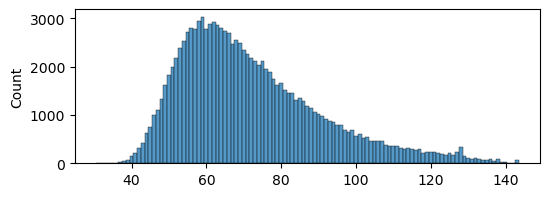

In [262]:
plt.figure(figsize=[6,2])
no_self_rank = ranking.filter(pl.col('question_idx') > pl.col('found_question_id'))
sns.histplot(no_self_rank['score'])

In [263]:
high_rank = no_self_rank.filter(pl.col('score') > 115)

In [264]:
to_delete = high_rank.filter(pl.col('question_idx') < pl.col('found_question_id'))['found_question_id'].unique()
to_delete

found_question_id
i64


In [265]:
train.shape

(54725, 9)

In [266]:
to_save = train.filter(~pl.col('question_id').is_in(to_delete))
to_save.write_parquet('./data/large_train_deduped.parquet')
to_save.shape

(54725, 9)

In [233]:
pl.Config(fmt_str_lengths=2000);

In [251]:
i = 0
print(high_rank[i]['score'].item())
j = high_rank[i]['found_question_id'].item()
i_q_idx = high_rank[i]['question_idx'].item()
print(i_q_idx, j)
train[[i_q_idx, j]]

131.25
118 118


question_id,question,A,C,B,D,E,answer,dataset_name
u32,str,str,str,str,str,str,str,str
118,"""What determines the quality of a ruby and affects its value?""","""Its color, cut, clarity, and carat weight.""","""The type of corundum it belongs to and the element chromium in it.""","""The level of silk in the gem and whether it has been heat treated.""","""The size, number, location, and visibility of inclusions.""","""The brightness and shade of red, and whether it is a birthstone for July.""","""A""","""daniel"""
118,"""What determines the quality of a ruby and affects its value?""","""Its color, cut, clarity, and carat weight.""","""The type of corundum it belongs to and the element chromium in it.""","""The level of silk in the gem and whether it has been heat treated.""","""The size, number, location, and visibility of inclusions.""","""The brightness and shade of red, and whether it is a birthstone for July.""","""A""","""daniel"""


In [125]:
train.columns

['question', 'A', 'C', 'B', 'D', 'E', 'answer', 'dataset_name']

In [127]:
daniel.shape

(12949, 9)

In [126]:
daniel.unique(subset=['title', 'section_title'])

question,title,section_title,A,B,C,D,E,answer
str,str,str,str,str,str,str,str,str
"""What is the main purpose of the ANTARES project?""","""ANTARES (telescope)""","""Experimental goals""","""ANTARES is an observatory that studies the behavior of black holes in the center of galaxies and their impact on the surrounding space.""","""ANTARES is a neutrino detector designed to locate and observe neutrino flux from cosmic origins in the Southern Hemisphere of the Earth.""","""ANTARES is a particle accelerator that aims to collide high-energy particles to create new particles and study their properties.""","""ANTARES is a satellite that is orbiting the Earth to study the effects of microgravity on plant growth and development.""","""ANTARES is a solar telescope focused on studying the dynamics of the Sun's outer atmosphere and its magnetic field.""","""B"""
"""What is the primary control theory input on bikes?""","""Bicycle and motorcycle dynamics""","""Braking technique""","""The primary control theory input on bikes is the speed of the bike, not the steering torque.""","""The primary control theory input on bikes is the length of the wheelbase, not the steering torque.""","""The primary control theory input on bikes is steering torque, not position.""","""The primary control theory input on bikes is the rider's weight distribution, not the steering torque.""","""The primary control theory input on bikes is the position of the handlebars, not the torque.""","""C"""
"""What is a Fermi gas and how is it characterized in thermal equilibrium? ""","""Fermi gas""","""Treatment at finite temperature""","""A Fermi gas is an idealized model of many interacting bosons, such as photons, mesons, and gluons. It is characterized in thermal equilibrium by the energy distribution of bosons, which is determined by their number density, temperature, and the set of available energy states.""","""A Fermi gas is an idealized model of many non-interacting fermions, such as electrons, protons, and neutrons. It is characterized in thermal equilibrium by the energy distribution of fermions, which is determined by their number density, temperature, and the set of available energy states.""","""A Fermi gas is an idealized model of many non-interacting fermions, such as electrons, protons, and neutrons. It is characterized in thermal equilibrium by the energy distribution of fermions, which is determined by their spin, mass, and the set of available energy levels.""","""A Fermi gas is a model of many interacting bosons, such as photons, mesons, and gluons. It is characterized in thermal equilibrium by the energy distribution of bosons, which is determined by their spin, mass, and the set of available energy levels.""","""A Fermi gas is a model of many interacting fermions, such as electrons, protons, and neutrons. It is characterized in thermal equilibrium by the energy distribution of fermions, which is determined by their spin, mass, and the set of available energy levels.""","""B"""
"""What are the two distinctively different types of rheometers?""","""Rheometer""","""Other types of extensional rheometers""","""Rotational or shear type rheometers and rheometers that apply extensional stress or extensional strain.""","""Rotational or shear type rheometers and capillary/contraction flow rheometers.""","""Rotational or shear type rheometers and acoustic rheometers.""","""Acoustic rheometers and falling plate rheometers.""","""Rotational or shear type rheometers and falling plate rheometers.""","""A"""
"""What is silk and how is it produced?""","""Silk""","""Medicine""","""Silk is a type of wool fiber obtained from sheep. The shimmering appearance of silk is due to the spiral-like structure of the silk fiber. Silk is mainly produced by the larvae of spiders.""","""Silk is a natural fiber protein fiber produced by certain insect larvae to form cocoons. The shimmering appearance of silk is due to the triangular-like structure of the silk fiber. Silk is mainly pr

In [129]:
daniel = pl.concat([
    pl.read_parquet('./data/daniel_train/train_shuffled.parquet'),
    pl.read_parquet('./data/daniel_train/train_shuffled_v_2.parquet')
])
daniel = daniel.unique(subset=['title', 'section_title'])
daniel.write_parquet('./data/daniel_train/combined_deduped.parquet')

In [130]:
daniel.filter(pl.Series(daniel[['title', 'section_title']].is_duplicated())).sort('title')

question,title,section_title,A,B,C,D,E,answer
str,str,str,str,str,str,str,str,str


In [10]:
names = ['daniel', 'osmu_sci_6k', 'osmu_5_9k', 'osmu_15k', 'mgoksu', 'gigkpea']
os.makedirs('./data/train_dedupe', exist_ok=True)
for dataset_name in names:
    train.filter(pl.col('dataset_name') == dataset_name)\
         .write_parquet(f'./data/train_dedupe/{dataset_name}.parquet')